<h2> Análise das taxas de conversão sobre operações de crédito em dólar estadunidense</h2>
<h3> Desenvolvido por Ana Letícia Souza </h3>
<h4> Disponível em https://github.com/analetisouza/taxa_dolar_credito <h4>

<p> Este trabalho objetiva realizar uma análise dos valores das taxas de conversão de dólar em compras internacionais efetuadas com cartão de crédito. Desta forma, visaremos ranquear os bancos examinando os valores por eles praticados, não apenas considerando as taxas de conversão mais baixas, mas também as menores taxas de variação, que podem ser mais vantajosas no longo prazo. As taxas de cotação de compra do dólar comercial também foram adicionadas com o intuito de serem um ponto de comparação. Os dados foram extraídos das APIs do Bradesco, da Caixa, do Itaú, do Nubank e do Banco Central do Brasil.</p>

<h3> Preparação Inicial </h3>

<p>Importação das bibliotecas necessárias e gerenciamento de possíveis erros durante os acessos às APIs. </p>

In [1]:
import pandas     as pd
import numpy      as np
import matplotlib as plt
import requests
import json
import ssl 


In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


<h3> Captura dos Dados </h3>

In [3]:
source_bradesco = "https://proxy.api.prebanco.com.br/bradesco/dadosabertos/taxasCartoes/itens"
source_caixa = "https://api.caixa.gov.br:8443/dadosabertos/taxasCartoes/1.2.0/itens"
source_itau = "https://api.itau.com.br/dadosabertos/taxasCartoes/taxas/itens"
source_nubank = "https://dadosabertos.nubank.com.br/taxasCartoes/itens"
source_cotacao = "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='06%2F08%2F2020'&@dataFinalCotacao='10%2F18%2F2020'&$top=10000&$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao"

In [4]:
inicio_analise =  pd.to_datetime("2020-10-05")
periodo_analise = 30
dias_excluidos = ["2020-10-04", "2020-10-03", "2020-09-27", "2020-09-26", "2020-09-20", "2020-09-19", "2020-09-13", "2020-09-12", "2020-09-07", "2020-09-06", "2020-09-05", "2020-08-30", "2020-08-29"]

for i in range(len(dias_excluidos)):
    dias_excluidos[i] = pd.to_datetime(dias_excluidos[i])

<p>Aqui foram definidas algumas variáveis para nortear a análise. Durante o tratamento dos dados, percebi que alguns bancos atualizavam as informações todos os dias, enquanto outros atualizavam apenas nos dias úteis. Como possível solução, decidi que a melhor escolha seria remover os dias que não estavam presentes em todos os datasets, buscando deixá-los mais uniformes. A ideia inicial era utilizar uma API que fornecesse os finais de semana e feriados, de forma que permitisse que a exploração dos dados fosse mais flexível. Como não consegui encontrar nenhuma gratuita, inseri os dados manualmente referente ao período de 30 dias que estipulei para este estudo. </p>

In [5]:
def prepara_dataframe(source):

    df_linha = pd.DataFrame()

    if source == source_itau: 
        df_source = json.loads(requests.get(source_itau).text)
        df_source = pd.DataFrame(df_source[0])
        df_source = df_source.at[0, 'itens']
        df_emissor = pd.DataFrame(df_source['emissor'], index = [0])
        df_historico = pd.DataFrame(df_source['historicoTaxas'])

        for linha in range(df_historico.shape[0]):
            df_linha = pd.concat([df_linha, df_emissor], ignore_index = True)
            df_historico['taxaData'] = pd.to_datetime(df_historico['taxaData'])
            df_source = df_linha

        df_source = pd.concat([df_source, df_historico], axis = 1)
        df_source = df_source.drop(columns = ['emissorCnpj', 'taxaDivulgacaoDataHora'])

    elif source == source_cotacao:
        df_source = pd.read_json(source)
        hist_source = df_source.iloc[:,[1]]
        df_historico = pd.DataFrame()

        for linha in range(hist_source.shape[0]):
            df_linha = pd.DataFrame(hist_source.at[linha,'value'], index = [0])
            df_linha['dataHoraCotacao'] = pd.to_datetime(df_linha['dataHoraCotacao']).dt.date
            df_historico = pd.concat([df_historico, df_linha], ignore_index = True)
            df_source = df_historico

    else:
        df_source = pd.read_json(source)
        hist_source = df_source.iloc[:,[2]]
        df_historico = pd.DataFrame()

        for linha in range(hist_source.shape[0]):
            df_linha = pd.DataFrame(hist_source.at[linha,'historicoTaxas'], index = [0])
            df_linha['taxaData'] = pd.to_datetime(df_linha['taxaData'])
            df_historico = pd.concat([df_historico, df_linha], ignore_index = True)

        df_source = pd.concat([df_source, df_historico], axis = 1)
        df_source = df_source.drop(columns = ['emissorCnpj', 'historicoTaxas', 'taxaDivulgacaoDataHora'])
    return df_source

<p> Essa função é responsável por ler os dados json retirado das APIs e organizá-los em dataframes. Nesse primeiro momento, os dados de cada banco têm seu dataframe individual.</p>

In [6]:
df_bradesco = prepara_dataframe(source_bradesco)
df_caixa = prepara_dataframe(source_caixa)
df_itau = prepara_dataframe(source_itau)
df_nubank = prepara_dataframe(source_nubank)
df_cotacao = prepara_dataframe(source_cotacao)

<h3> Limpeza dos Dados </h3>

<p> Aqui os dados já foram organizados em dataframes mas precisam ser refinados para que sigam o mesmo padrão. </p>


In [7]:
def altera_data_inicio(df, df_data, inicio):

    for linha in range(df.shape[0]):

        if df_data[linha] == inicio:
            return df

        else:
            df = df.drop(linha)

In [8]:
def altera_dias_uteis(df, df_data):

    quantidade_dias = len(dias_excluidos)
    linha = 0

    for contador in range(quantidade_dias):

        while not df_data[linha] == dias_excluidos[contador]:
            linha = linha + 1

        df = df.drop(linha)
        linha = linha + 1
        
    return df

<p> A primeira etapa é remover os dados referentes à operações de débito do Banco Bradesco, pois estamos trabalhando apenas com crédito. Logo em seguida, invertemos a ordem do dataset, para que comece pela data mais recente, assim como os demais. </p>

In [9]:
df_bradesco = df_bradesco.drop(df_bradesco.loc[df_bradesco['taxaTipoGasto'] == 'Débito à conta'].index)
df_bradesco = df_bradesco.iloc[::-1].reset_index(drop = True)
df_cotacao = df_cotacao.iloc[::-1].reset_index(drop = True)


<p> Após, mantemos apenas os dias úteis nos datasets que incluem fins de semana e feriados. </p>

In [10]:
df_itau = altera_dias_uteis(df_itau, df_itau["taxaData"])
df_nubank = altera_dias_uteis(df_nubank, df_nubank["taxaData"])

<p> Como alguns bancos atualizam seus dados antes que outros, pode ocorrer que a data mais recente de um não esteja disponível ainda no outro. Sendo assim, escolhi uma data que estivesse presente em todos e defini como ponto de partida, removendo as anteriores à ela. </p>

In [11]:
df_bradesco = altera_data_inicio(df_bradesco, df_bradesco["taxaData"], inicio_analise)
df_caixa = altera_data_inicio(df_caixa, df_caixa["taxaData"], inicio_analise)
df_itau = altera_data_inicio(df_itau, df_itau["taxaData"], inicio_analise)
df_nubank = altera_data_inicio(df_nubank, df_nubank["taxaData"], inicio_analise)
df_cotacao = altera_data_inicio(df_cotacao, df_cotacao["dataHoraCotacao"], inicio_analise)

<p>Neste ponto as alterações realizadas anteriormente desorganizaram a indexação do dataframe. Por isso, realizaremos as operações abaixo para reestabecê-la em cada dataframe. </p>

In [12]:
df_bradesco = df_bradesco.reset_index(drop = True)
df_caixa = df_caixa.reset_index(drop = True)
df_itau = df_itau.reset_index(drop = True)
df_nubank = df_nubank.reset_index(drop = True)
df_cotacao = df_cotacao.reset_index(drop = True)

<p>O comando seguinte substitui alguns dados do dataset da Caixa, novamente com o intuito de seguir a mesma linha que os demais. </p>

In [13]:
df_caixa = df_caixa.replace({'CAIXA ECONOMICA FEDERAL' : 'Caixa Economica Federal', 'CREDITO' : 'Crédito'})


<p>Levando em consideração que os datasets abrangem períodos diferentes e para tornar os dados mais enxutos, todos os dataframes foram reduzidos para os últimos 30 dias úteis. </p>


In [14]:
df_bradesco = df_bradesco.loc[:29]
df_caixa = df_caixa.loc[:29]
df_itau = df_itau.loc[:29]
df_nubank = df_nubank.loc[:29]
df_cotacao = df_cotacao.loc[:29]

<p>Para facilitar a apuração dos dados, as infromações mais importantes de cada dataframe foram extraídas e reunidas em um único dataframe geral.</p>

In [15]:
df_analise = pd.DataFrame()
df_analise.insert(0, 'Data', df_cotacao["dataHoraCotacao"])
df_analise.insert(1, 'Compra', df_cotacao["cotacaoCompra"])
df_analise.insert(2, 'Bradesco', df_bradesco["taxaConversao"])
df_analise.insert(3, 'Caixa', df_caixa["taxaConversao"])
df_analise.insert(4, 'Itaú', df_itau["taxaConversao"])
df_analise.insert(5, 'Nubank', df_nubank["taxaConversao"])

<h3> Análise dos Dados </h3>


In [53]:
print(df_analise)

          Data  Compra  Bradesco   Caixa  Itaú  Nubank
0   2020-10-05  5.6293      5.93  5.8495  5.94  5.8551
1   2020-10-02  5.6458      5.95  5.8675  5.96  5.8723
2   2020-10-01  5.6435      5.94  5.8640  5.95  5.8699
3   2020-09-30  5.6401      5.94  5.8745  5.95  5.8663
4   2020-09-29  5.6521      5.95  5.8675  5.96  5.8789
5   2020-09-28  5.5852      5.88  5.8600  5.89  5.8092
6   2020-09-25  5.5661      5.86  5.7835  5.87  5.7894
7   2020-09-24  5.5708      5.87  5.7885  5.88  5.7943
8   2020-09-23  5.5305      5.82  5.7925  5.83  5.7523
9   2020-09-22  5.4323      5.72  5.6745  5.73  5.6502
10  2020-09-21  5.4434      5.73  5.6560  5.74  5.6618
11  2020-09-18  5.2883      5.57  5.5805  5.58  5.5005
12  2020-09-17  5.2587      5.54  5.4750  5.55  5.4697
13  2020-09-16  5.2526      5.53  5.4580  5.54  5.4633
14  2020-09-15  5.2722      5.55  5.4965  5.56  5.4837
15  2020-09-14  5.2978      5.58  5.5090  5.59  5.5103
16  2020-09-11  5.2848      5.57  5.5500  5.58  5.4968
17  2020-0

<p> Formatação final do dataset a ser avaliado. </p>

In [17]:
df_analise.describe()

,Compra,Bradesco,Caixa,Itaú,Nubank
count,30.00000,30.000000,30.000000,30.000000,30.000000
mean,5.45298,5.742333,5.681667,5.752000,5.671727
std,0.14541,0.152918,0.147589,0.153317,0.151235
min,5.25260,5.530000,5.458000,5.540000,5.463300
25%,5.29880,5.580000,5.534625,5.590000,5.511350
50%,5.45535,5.745000,5.674750,5.755000,5.674200
75%,5.59240,5.887500,5.821000,5.897500,5.816700
max,5.65210,5.950000,5.874500,5.960000,5.878900


<p> Observando apenas os dados numéricos, pode-se notar que apesar da Caixa possui os menores valores minímo e máximo, o Nubank possui a melhor média, o que no longo prazo, com compras frequentes, apresentaria maior economia. Se tratando de centésimos de difereça e muito provavelmente não causando um impacto relevante nas finanças do consumidor, fica claro que qualquer uma das duas opções leva uma grande vantagem em relação aos outros dois, Bradesco e Itaú. </p>

<AxesSubplot:xlabel='Data'>

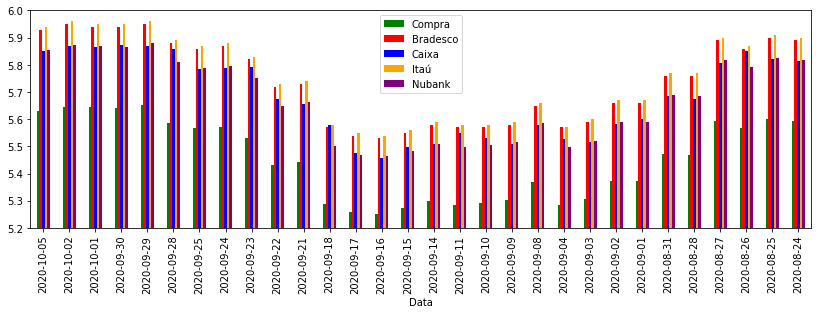

In [68]:
df_analise.plot.bar(x = 'Data', color = { 'Compra' : 'green', 'Bradesco' : 'red', 'Caixa' : 'blue', 'Itaú' : 'orange', 'Nubank' : 'purple'}, figsize = (14,4), ylim = (5.2,6),)

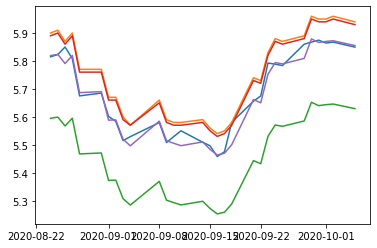

In [66]:
plt.plot(df_analise['Data'], df_analise['Caixa'], df_analise['Data'], df_analise['Itaú'], df_analise['Data'], df_analise['Compra'], df_analise['Data'], df_analise['Bradesco'], df_analise['Data'], df_analise['Nubank'])

<p> Prestando atenção nos gráficos acima, fica ainda mais claro perceber as poucas, mas existentes diferenças. Apesar do Nubank possuir inúmeros pontos que seu valor ultrapassa o da Caixa, no geral, sua linha permanece abaixo da mesma. </p>

array([[<AxesSubplot:title={'center':'Compra'}>,
        <AxesSubplot:title={'center':'Bradesco'}>],
       [<AxesSubplot:title={'center':'Caixa'}>,
        <AxesSubplot:title={'center':'Itaú'}>],
       [<AxesSubplot:title={'center':'Nubank'}>, <AxesSubplot:>]],
      dtype=object)

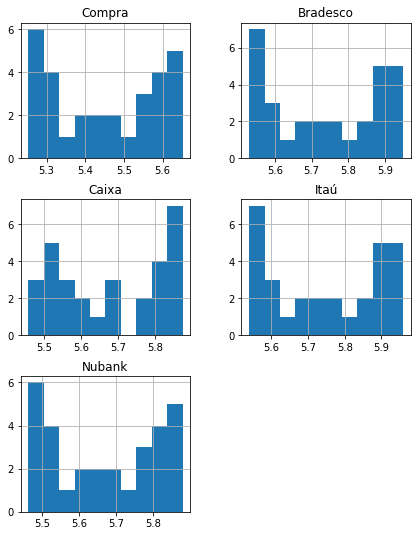

In [37]:
df_analise.hist(figsize = (7,9))

<p> Também é possível notar pelo histograma, que a frequência de valores baixos e médios é maior no Nubank do que na Caixa, o que contribui para uma média menor. </p>

<p> Concluindo, o objetivo desta investigação não é enaltecer nenhuma instituição financeira, mas sim exibir a discrepância entre os valores estabelecidos, bastante surprendentes em alguns casos, que sem um olhar mais clínico é difícil notar.  Um dos papéis que eu enxergo na Ciência de Dados é justamente utilizar a informação para que decisões melhores e mais conscientes sejam tomadas, baseadas em fatos. </p>